In [4]:
from IPython.display import Image
from IPython.display import display
%matplotlib inline

## Convolutional Neural Network - Part 2

Application of CNN in Nuclear Physics


### 📘 Background: PD4ML Benchmark & Spinodal Dataset

**Physics Datasets for Machine Learning** is a Python-based benchmark suite that provides standardized access to a collection of datasets originating from fundamental physics research domains—including particle physics, astroparticle physics, and nuclear/hadronic matter. The initiative enables supervised machine learning studies on structured physics data using a **unified interface** and includes reference implementations to support cross-domain research.Introduced in the paper:

> **"Shared Data and Algorithms for Deep Learning in Fundamental Physics"**  
> [ArXiv:2107.00656](https://arxiv.org/abs/2107.00656)

The included datasets span diverse phenomena such as:
- Hadronic top quark decays,
- Cosmic-ray induced air showers,
- Generator-level event histories,
- And **phase transitions in hadronic matter**, including spinodal decomposition.

PD4ML also offers guidelines for submitting new datasets and provides **graph-based neural network (GNN)** baselines that can generalize across multiple tasks, achieving near state-of-the-art performance using a simple architecture.

---


### The Spinodal Dataset

One of the included datasets in PD4ML is based on the work:

> **"A machine learning study to identify spinodal clumping in high energy nuclear collisions"**  
> Jan Steinheimer et al., [ArXiv:1906.06562](https://arxiv.org/abs/1906.06562)

This dataset models **spinodal decomposition**—a signal of a **first-order QCD phase transition**—through relativistic fluid dynamics simulations of **Pb+Pb heavy-ion collisions**. These simulations compare two thermodynamic scenarios:
- The **Spinodal EoS**, which allows for mechanical instability and clustering,
- And the **Maxwell EoS**, which describes an equilibrium transition without clumping.

Each collision event is represented as a **20×20 image** of the net baryon density distribution in the transverse X–Y plane at fixed time $ t = 3 \, \text{fm}/c $, when fluctuation effects are strongest. These images serve as input to deep learning models for **binary classification**, distinguishing between spinodal (`1`) and non-spinodal (Maxwell `0`) events.

### What is Spinodal Decomposition? (An experimentalist perspective)

> *Note*: Take this with a grain of salt.

When we collide heavy ions like lead nuclei together at very high energies, we briefly create **extreme conditions**—very hot and very dense nuclear matter. Under such conditions, the matter may undergo a **phase transition** of **hadronic matter** (made of protons and neutrons) possibly turning into **quark-gluon plasma** .

In these systems, a phase transition can happen smoothly (a **crossover**) or sharply (**first-order**) just like ice melting or water boiling. In the case of **first-order transitions**, there's often a region where the system becomes **unstable**, and small fluctuations can grow dramatically.

This unstable region is known as the **spinodal region**, and the process where small fluctuations in density **grow into visible patterns or clumps** is called **spinodal decomposition**.

### 🕒 Time Evolution in the Spinodal Simulation

The Spinodal dataset is generated from **time-resolved simulations** of heavy-ion (Pb+Pb) collisions using **UrQMD** (Ultra-relativistic Quantum Molecular Dynamics). These simulations model how hot and dense nuclear matter evolves **over time**, from the moment two nuclei collide to the stage where particles are formed and freeze out.

---

### ⏳ How Does the System Evolve?

The simulation tracks the system through several key stages:

1. **Initial collision (t ≈ 0 fm/c)**  
   Two lead nuclei collide at high energy, compressing and heating nuclear matter.

2. **Compression & heating phase**  
   Matter becomes extremely dense and may enter the region of the QCD phase diagram where a **first-order phase transition** occurs.

3. **Passage through the spinodal region**  
   - If the equation of state allows it, the system becomes **mechanically unstable**.
   - Small density fluctuations grow into visible **clumps** — this is **spinodal decomposition**.

4. **Maximal density fluctuation (t = 3 fm/c)**  
   The simulation reaches the moment where clumping patterns are most pronounced.

5. **Expansion and freeze-out (later times)**  
   The system expands and cools, eventually forming hadrons (particles like protons and neutrons), which fly out to the detector.

---

### Why It Matters in Nuclear Collisions

In heavy-ion collisions:
- If the system **passes through the spinodal region**, it might **develop clumps of baryons** (particles like protons and neutrons).
- These clumps are **not random**—they're a signature of the phase transition happening **out of equilibrium**.
- Detecting these clumps in simulation is challenging, but they can leave **patterns** in the spatial distributions of particles.

This is what the **Spinodal dataset** captures:
- Simulated images of net baryon density, where some events have gone through this clumping (spinodal) and others have not (Maxwell -- these are thermodynamically stable.)
- Our job is to train a neural network to learn the **hidden features** that distinguish these two cases, just from the images.

So in short, **spinodal decomposition is a fingerprint of a violent, out-of-equilibrium transformation of matter**, and detecting it could help physicists understand the phase structure of the universe’s most fundamental particles.

This notebook will focus on using **Convolutional Neural Networks (CNNs)** to classify events from this dataset, illustrating how modern ML techniques can extract subtle physical signatures from event-by-event data.


#### Loading and preprocessing the data

For ease of use, I have downloaded the dataset and saved it as a `pkl` file in the `data` folder in [github.com/cfteach/HUGS2025](https://github.com/cfteach/HUGS2025)

In [5]:
!wget https://raw.githubusercontent.com/cfteach/HUGS2025/data/CNN/HUGS2025_CNN_train.pkl
!wget https://raw.githubusercontent.com/cfteach/HUGS2025/data/CNN/HUGS2025_CNN_test.pkl

--2025-06-03 00:04:36--  https://raw.githubusercontent.com/cfteach/HUGS2025/data/CNN/train.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2025-06-03 00:04:36 ERROR 404: Not Found.

--2025-06-03 00:04:36--  https://raw.githubusercontent.com/cfteach/HUGS2025/data/CNN/test.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2025-06-03 00:04:36 ERROR 404: Not Found.



In [6]:
import pickle as pkl
# lets load the data from the pickle files

with open("HUGS2025_CNN_train.pkl", "rb") as f:
    X_train, y_train = pkl.load(f)

with open("HUGS2025_CNN_test.pkl", "rb") as f:
    X_test, y_test = pkl.load(f)


In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, TensorDataset

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
else:
  print('cpu')

cuda
Tesla T4


In [9]:
# checking basic content

print (type(X_train))
print (type(y_train))
print (type(X_test))
print (type(y_test))
print(len(X_train))
print(len(X_test))

print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20300
8700
(20300, 20, 20)
(8700, 20, 20)
(20300,)
(8700,)


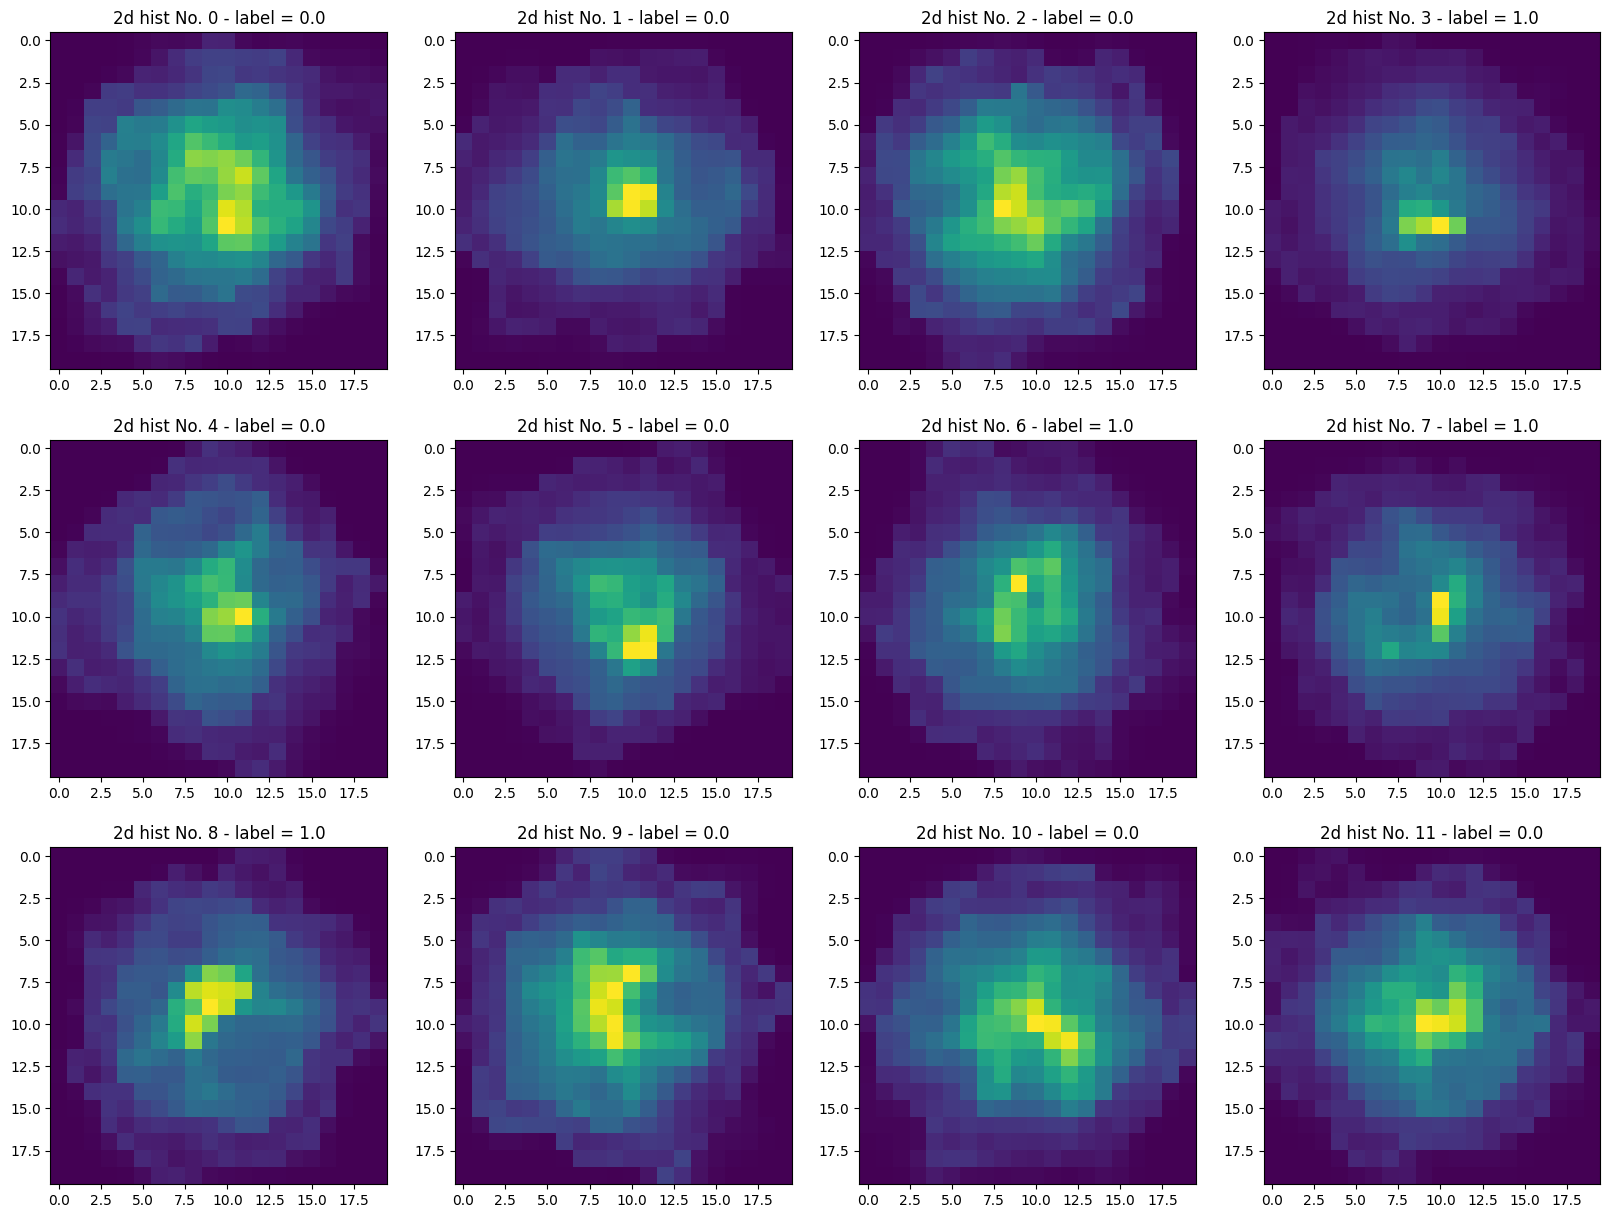

In [10]:
# example 2d histograms
from matplotlib import pyplot as plt
X = X_train
y = y_train

fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(20, 15))
for i, (ax) in enumerate(np.array(axs).ravel()):
    ax.imshow(X[i,:,:])
    ax.set_title('2d hist No. {} - label = {}'.format(i, y[i]))



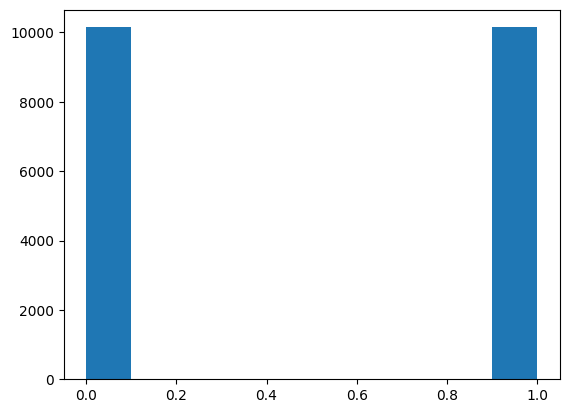

In [11]:
# labels
plt.clf()
plt.hist(y_train, bins = 10)
plt.show()



torch.Size([64, 1, 20, 20])
torch.Size([64])


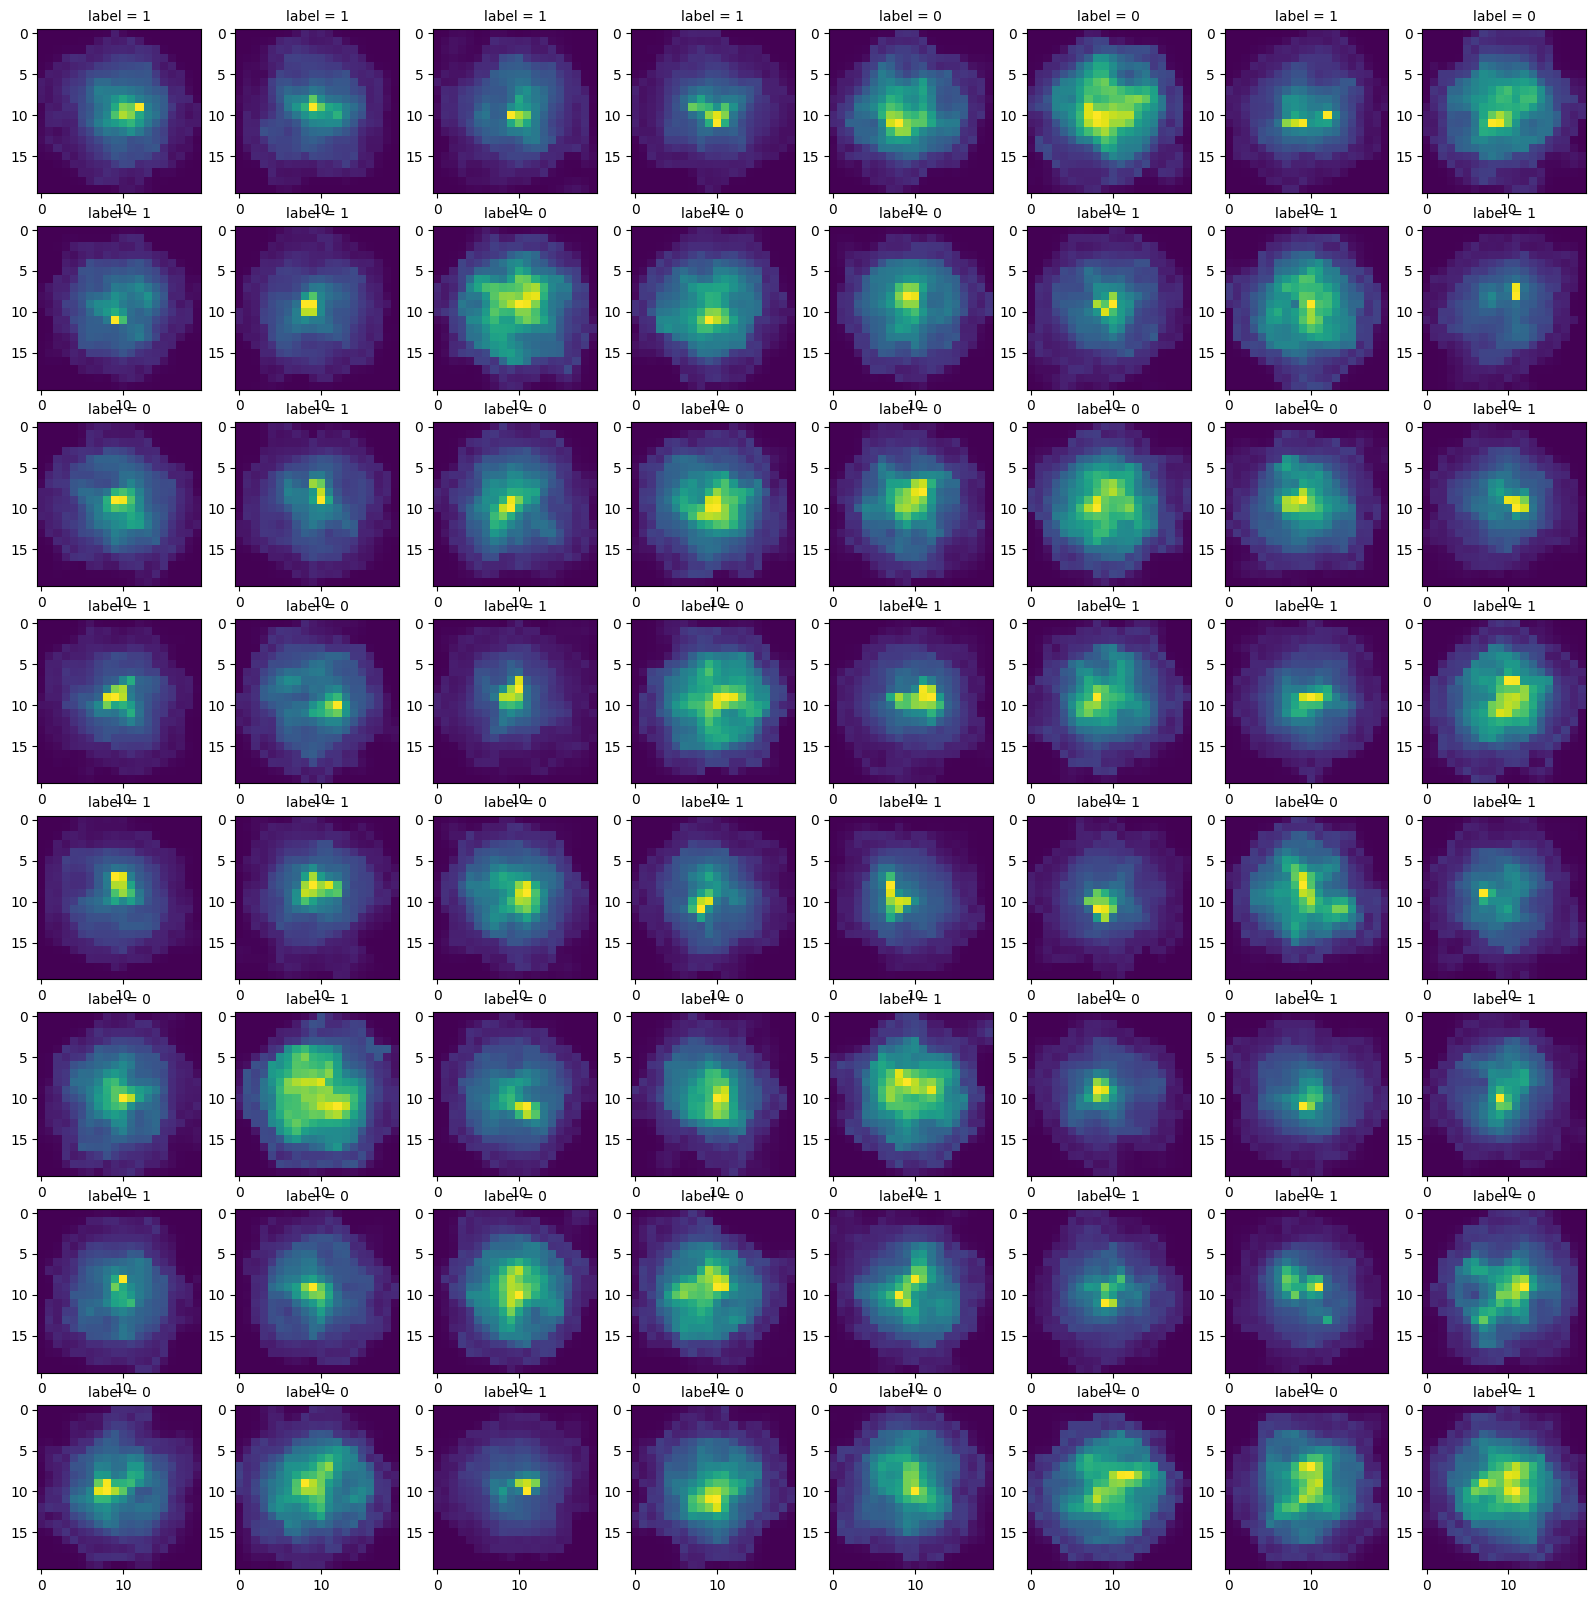

In [12]:
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split


#y_train_one_hot = F.one_hot(torch.tensor(y_train, dtype = int), num_classes=2).float()
#y_test_one_hot = F.one_hot(torch.tensor(y_test, dtype = int), num_classes=2).float()
if (X_train.ndim == 3):
    X_train = torch.Tensor(X_train).unsqueeze(1)
    X_test = torch.Tensor(X_test).unsqueeze(1)
else:
    X_train = torch.Tensor(X_train)
    X_test = torch.Tensor(X_test)

TRAIN_DATASET = TensorDataset(X_train, torch.tensor(y_train, dtype = int))
test_dataset = TensorDataset(X_test, torch.tensor(y_test, dtype = int))

train_val_split = 0.8
train_val_lengths = [int(len(TRAIN_DATASET)*train_val_split), len(TRAIN_DATASET)-int(len(TRAIN_DATASET)*train_val_split)]
train_dataset, val_dataset = random_split(TRAIN_DATASET, train_val_lengths)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

batch_shape = None
# lets test the loaders
for tmpbatch in train_loader:
  print (tmpbatch[0].shape)
  print (tmpbatch[1].shape)
  batch_shape = tmpbatch[0].shape
  # Lets plot the images with labels
  fig, axs = plt.subplots(nrows=8, ncols=8, figsize=(20, 20))
  for i, (ax) in enumerate(np.array(axs).ravel()):
    ax.imshow(tmpbatch[0][i,0,:,:])
    ax.set_title('label = {}'.format(tmpbatch[1][i]), fontsize = 10)
  plt.show()
  break

In [13]:
print(len(train_dataset),len(val_dataset),len(test_dataset))

sample_image, sample_label = train_dataset[0]

print(sample_image.shape, sample_label)

# consistent NCHW format



16240 4060 8700
torch.Size([1, 20, 20]) tensor(1)


### Constructing a CNN in PyTorch

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch
import torch.nn as nn
import torch.nn.functional as F

def get_trainable_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

class SpinodalCNN(nn.Module):
    def __init__(self, input_shape=(1, 20, 20)):
        super(SpinodalCNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 15, kernel_size=3, padding=1)  # "same" padding
        self.conv2 = nn.Conv2d(15, 15, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.conv3 = nn.Conv2d(15, 25, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.dropout = nn.Dropout(0.4)

        # Flattened size (computed once using dummy input)
        self.flattened_size = self._get_flattened_size(input_shape)

        # Fully connected layers
        self.fc1 = nn.Linear(self.flattened_size, 10)
        self.fc2 = nn.Linear(10, 1)

    def _get_flattened_size(self, input_shape):
        with torch.no_grad():
            dummy = torch.zeros(1, *input_shape)
            x = F.relu(self.conv1(dummy))
            x = F.relu(self.conv2(x))
            x = self.pool1(x)
            x = F.relu(self.conv3(x))
            x = self.pool2(x)
            return x.view(1, -1).size(1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = F.relu(self.conv3(x))
        x = self.pool2(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))  # For BCELoss
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SpinodalCNN()
model = model.to(device)
print (model)
print (f'Model has {get_trainable_params(model):.2e} trainable parameters')
print (f"Model is on {device}")



SpinodalCNN(
  (conv1): Conv2d(1, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(15, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(15, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc1): Linear(in_features=625, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=1, bias=True)
)
Model has 1.19e+04 trainable parameters
Model is on cuda


In [15]:
# Lets try compute input for train

for tmpx, tmpy in train_loader:
  tmpx = tmpx.to(device)
  tmpy = tmpy.to(device)
  print(f"input shape is {tmpx.shape}, and output shape is {model(tmpx.float()).shape}")
  break

input shape is torch.Size([64, 1, 20, 20]), and output shape is torch.Size([64, 1])


In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

def train_spinodal_cnn(model, train_loader, val_loader=None,
                       epochs=5, lr=1e-3, start = 0,
                       device='cuda' if torch.cuda.is_available() else 'cpu',
                       metrics = None
                       ):
    if metrics is None:
        metrics = {
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': []
        }
    model.to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(start, start + epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device).float(), labels.to(device).float().unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(inputs)  # sigmoid outputs in [0,1]
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Track stats
            running_loss += loss.item() * inputs.size(0)
            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        avg_loss = running_loss / total
        acc = correct / total * 100
        print(f"[Epoch {epoch+1:02d}] Train Loss: {avg_loss:.4f} | Train Acc: {acc:.2f}%")
        metrics['train_loss'].append(avg_loss)
        metrics['train_acc'].append(acc)

        # Optional validation
        if val_loader:
            model.eval()
            val_loss, val_correct, val_total = 0.0, 0, 0
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device).float(), labels.to(device).float().unsqueeze(1)

                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    val_loss += loss.item() * inputs.size(0)
                    preds = (outputs > 0.5).float()
                    val_correct += (preds == labels).sum().item()
                    val_total += labels.size(0)

            avg_val_loss = val_loss / val_total
            val_acc = val_correct / val_total * 100
            print(f"              Val Loss:   {avg_val_loss:.4f} | Val Acc:   {val_acc:.2f}%")
            metrics['val_loss'].append(avg_val_loss)
            metrics['val_acc'].append(val_acc)

    return (model, metrics)


In [17]:
try:
    start = len(metrics['train_loss'])
    metrics = metrics
except:
    start = 0
    metrics = None
trained_model, metrics = train_spinodal_cnn(model, train_loader, val_loader, epochs=25, start = start, metrics= metrics, device=device)

[Epoch 01] Train Loss: 0.5110 | Train Acc: 75.02%
              Val Loss:   0.4469 | Val Acc:   80.00%
[Epoch 02] Train Loss: 0.4622 | Train Acc: 79.19%
              Val Loss:   0.4612 | Val Acc:   78.60%
[Epoch 03] Train Loss: 0.4534 | Train Acc: 79.62%
              Val Loss:   0.4366 | Val Acc:   80.49%
[Epoch 04] Train Loss: 0.4446 | Train Acc: 80.18%
              Val Loss:   0.4400 | Val Acc:   80.20%
[Epoch 05] Train Loss: 0.4396 | Train Acc: 80.54%
              Val Loss:   0.4292 | Val Acc:   80.84%
[Epoch 06] Train Loss: 0.4341 | Train Acc: 80.81%
              Val Loss:   0.4108 | Val Acc:   81.95%
[Epoch 07] Train Loss: 0.4230 | Train Acc: 81.32%
              Val Loss:   0.4504 | Val Acc:   79.63%
[Epoch 08] Train Loss: 0.4174 | Train Acc: 81.77%
              Val Loss:   0.3980 | Val Acc:   82.59%
[Epoch 09] Train Loss: 0.4096 | Train Acc: 82.51%
              Val Loss:   0.4098 | Val Acc:   82.39%
[Epoch 10] Train Loss: 0.3980 | Train Acc: 83.06%
              Val Loss:

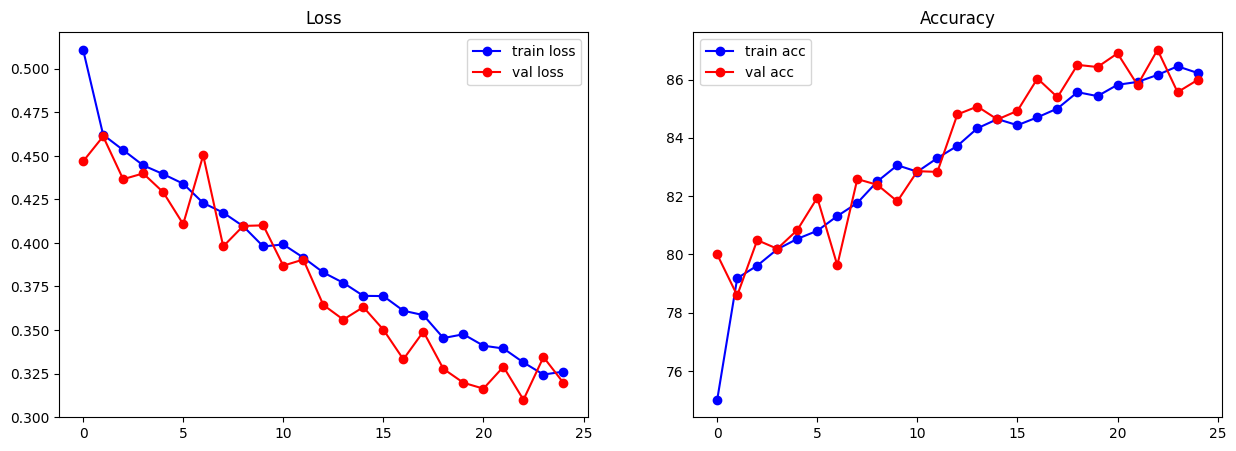

In [18]:
import matplotlib.pyplot as plt

# lets plots the metrics
fig, ax= plt.subplots(nrows = 1, ncols = 2, figsize = (15, 5))
ax[0].plot(metrics['train_loss'], 'bo-', label = 'train loss')
ax[0].plot(metrics['val_loss'], 'ro-', label = 'val loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[1].plot(metrics['train_acc'], 'bo-', label = 'train acc')
ax[1].plot(metrics['val_acc'], 'ro-', label = 'val acc')
ax[1].set_title('Accuracy')
ax[1].legend()
plt.show()

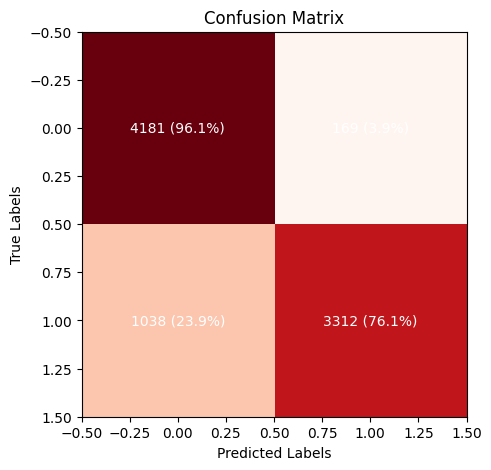

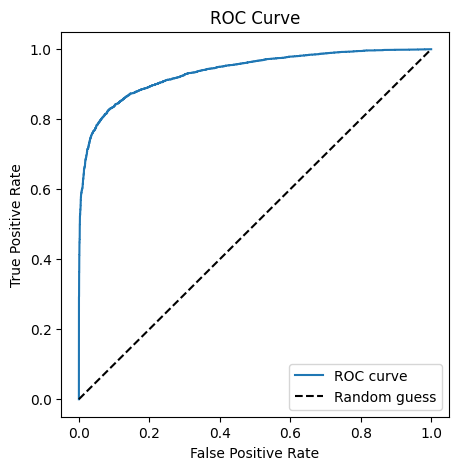

In [19]:
# Lets now test on test data and plot confusion metric as well. Also plot the ROC curve

from sklearn.metrics import confusion_matrix, roc_curve

y_pred = []
y_true = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device).float(), labels.to(device).float().unsqueeze(1)
        outputs = model(inputs)
        y_pred.extend(outputs.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

y_pred = np.array(y_pred)
y_true = np.array(y_true)

# lets compute confusion metric and ROC curve
cm = confusion_matrix(y_true, y_pred > 0.5)
# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Reds)
# put the percentage in each cell
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, f'{cm[i, j]} ({cm[i, j]/np.sum(cm[i, :])*100:.1f}%)', ha='center', va='center', color='white')
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

# lets plot the ROC curve
fpr, tpr, _ = roc_curve(y_true, y_pred)
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

### Introduction to Fine-Tuning a CNN

Now that we've prepared our dataset and constructed appropriate data loaders, it's time to train a Convolutional Neural Network (CNN). However, rather than training a model entirely from scratch—which requires large amounts of data and compute—we’ll adopt a more efficient approach known as **fine-tuning**.

Fine-tuning leverages a **pretrained model**—a model that has already learned useful image features by training on a large and diverse dataset, such as ImageNet, which contains over a million labeled images across 1,000 categories. The key idea is to **transfer** this prior knowledge to a new task, using a smaller, domain-specific dataset.

#### Why Use a Pretrained Model?

CNNs trained on large datasets like ImageNet learn to detect general visual patterns in their early layers—such as edges, gradients, and textures—that are useful for a wide range of vision tasks. These general-purpose features form the **backbone** of the model. By reusing them, we:

- Reduce training time.
- Require less data to achieve good performance.
- Improve generalization.

#### How Does Fine-Tuning Work?

In practice, we perform transfer learning in two main steps:

1. **Replace the classifier head**: Since our target task (e.g., classifying spinodal vs. Maxwell events) may have a different number of output classes than ImageNet, we discard the final classification layer (originally designed for 1,000 ImageNet classes) and replace it with a new, randomly initialized layer appropriate for our task (e.g., 2-class binary classification).

2. **Adapt the model**:
   - In **feature extraction mode**, we freeze all pretrained layers and train only the new head.
   - In **fine-tuning mode**, we allow some or all of the pretrained layers to update during training, letting the model adapt to the new dataset.

This approach is particularly effective when we have a small dataset and when the domain shares visual characteristics with natural images.

#### Summary

This strategy—reusing pretrained weights and adapting the model to a new task—is broadly referred to as **transfer learning**, and is a cornerstone of modern deep learning in fields ranging from computer vision and natural language processing to scientific data analysis.

![Fine tuning](https://raw.githubusercontent.com/lewtun/dl4phys/895cf8b9a1bb33b571153d5fb6c363c028a5f1b1/images/transfer-learning.png)


In [20]:
# Let us look into all the models torchvision has to offer
from torchvision import models
# https://docs.pytorch.org/vision/0.9/models.html
# List all available models
all_models = models.list_models()

for idx, name in enumerate(all_models):
    print (f"{idx+1}. {name}")

1. alexnet
2. convnext_base
3. convnext_large
4. convnext_small
5. convnext_tiny
6. deeplabv3_mobilenet_v3_large
7. deeplabv3_resnet101
8. deeplabv3_resnet50
9. densenet121
10. densenet161
11. densenet169
12. densenet201
13. efficientnet_b0
14. efficientnet_b1
15. efficientnet_b2
16. efficientnet_b3
17. efficientnet_b4
18. efficientnet_b5
19. efficientnet_b6
20. efficientnet_b7
21. efficientnet_v2_l
22. efficientnet_v2_m
23. efficientnet_v2_s
24. fasterrcnn_mobilenet_v3_large_320_fpn
25. fasterrcnn_mobilenet_v3_large_fpn
26. fasterrcnn_resnet50_fpn
27. fasterrcnn_resnet50_fpn_v2
28. fcn_resnet101
29. fcn_resnet50
30. fcos_resnet50_fpn
31. googlenet
32. inception_v3
33. keypointrcnn_resnet50_fpn
34. lraspp_mobilenet_v3_large
35. maskrcnn_resnet50_fpn
36. maskrcnn_resnet50_fpn_v2
37. maxvit_t
38. mc3_18
39. mnasnet0_5
40. mnasnet0_75
41. mnasnet1_0
42. mnasnet1_3
43. mobilenet_v2
44. mobilenet_v3_large
45. mobilenet_v3_small
46. mvit_v1_b
47. mvit_v2_s
48. quantized_googlenet
49. quantiz

### What is MobileNet?

**MobileNet** is a family of lightweight convolutional neural networks designed for efficient inference on mobile and embedded devices. Introduced by Google, MobileNet achieves high accuracy while maintaining a low computational footprint, making it ideal for applications where resources are limited.

MobileNet is built using a key architectural innovation called **depthwise separable convolutions**, which factorize a standard convolution into two operations:
1. A **depthwise convolution**, which applies a single filter per input channel.
2. A **pointwise convolution** (1×1 convolution), which linearly combines the outputs of the depthwise layer.

This factorization drastically reduces the number of parameters and computational cost, compared to standard convolutions, without a significant loss in accuracy.

MobileNet models are typically pretrained on the **ImageNet** dataset, which contains over 1.2 million images across 1,000 classes. Through this large-scale training, the network learns rich and general-purpose visual features such as edges, textures, and object parts. These learned weights are then transferred and fine-tuned on domain-specific datasets (like our spinodal classification images) to enable accurate and efficient task-specific models.


In [21]:
mobileNet = models.mobilenet_v2(weights = models.MobileNet_V2_Weights.DEFAULT)

print (mobileNet)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 154MB/s]

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [22]:
for name, param in mobileNet.named_parameters():
    print (name, param.shape)

features.0.0.weight torch.Size([32, 3, 3, 3])
features.0.1.weight torch.Size([32])
features.0.1.bias torch.Size([32])
features.1.conv.0.0.weight torch.Size([32, 1, 3, 3])
features.1.conv.0.1.weight torch.Size([32])
features.1.conv.0.1.bias torch.Size([32])
features.1.conv.1.weight torch.Size([16, 32, 1, 1])
features.1.conv.2.weight torch.Size([16])
features.1.conv.2.bias torch.Size([16])
features.2.conv.0.0.weight torch.Size([96, 16, 1, 1])
features.2.conv.0.1.weight torch.Size([96])
features.2.conv.0.1.bias torch.Size([96])
features.2.conv.1.0.weight torch.Size([96, 1, 3, 3])
features.2.conv.1.1.weight torch.Size([96])
features.2.conv.1.1.bias torch.Size([96])
features.2.conv.2.weight torch.Size([24, 96, 1, 1])
features.2.conv.3.weight torch.Size([24])
features.2.conv.3.bias torch.Size([24])
features.3.conv.0.0.weight torch.Size([144, 24, 1, 1])
features.3.conv.0.1.weight torch.Size([144])
features.3.conv.0.1.bias torch.Size([144])
features.3.conv.1.0.weight torch.Size([144, 1, 3, 3])

In [23]:
# Lets build a finetuned model using mobileNetV2
import torch, torchvision
import torch.nn as nn

class FinetunedMobileNet(nn.Module):
    def __init__(self, num_classes=1):
        super(FinetunedMobileNet, self).__init__()
        self.base_model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
        self.base_model.classifier[1] = nn.Linear(self.base_model.last_channel, num_classes)
        # lets match the 3 channel to 1 channel
        self.base_model.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        return self.sigmoid(self.base_model(x))

# Create the model
finetuned_MobileNet_model = FinetunedMobileNet()
finetuned_MobileNet_model = finetuned_MobileNet_model.to(device)
print(finetuned_MobileNet_model)

FinetunedMobileNet(
  (base_model): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kern

In [24]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, Dataset

# load training and testing set

with open("HUGS2025_CNN_train.pkl", "rb") as f:
    X_train, y_train = pkl.load(f)
with open("HUGS2025_CNN_test.pkl", "rb") as f:
    X_test, y_test = pkl.load(f)

# define transform to convert to tensor and resize
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(X_train[0].shape)
])


class SpinodalDataSet(Dataset):
    def __init__(self, X, y, transform):
        self.X = X
        self.y = y
        self.transform = transform
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        if self.transform:
            return self.transform(self.X[idx]), self.y[idx]
        else:
            return self.X[idx], self.y[idx]

TRAIN_DATASET = SpinodalDataSet(X_train, y_train, transform)
test_dataset = SpinodalDataSet(X_test, y_test, transform)

train_val_split = 0.8
train_val_lengths = [int(len(TRAIN_DATASET)*train_val_split), len(TRAIN_DATASET)-int(len(TRAIN_DATASET)*train_val_split)]
train_dataset, val_dataset = random_split(TRAIN_DATASET, train_val_lengths)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [25]:
trained_mobileNet, metrics_mobileNet = train_spinodal_cnn(finetuned_MobileNet_model, train_loader, val_loader, epochs=15, start = 0, lr=1e-3)


[Epoch 01] Train Loss: 0.5208 | Train Acc: 76.02%
              Val Loss:   0.4950 | Val Acc:   78.33%
[Epoch 02] Train Loss: 0.4659 | Train Acc: 79.89%
              Val Loss:   0.4425 | Val Acc:   80.17%
[Epoch 03] Train Loss: 0.4377 | Train Acc: 81.11%
              Val Loss:   0.4343 | Val Acc:   80.79%
[Epoch 04] Train Loss: 0.4219 | Train Acc: 81.72%
              Val Loss:   0.4260 | Val Acc:   81.16%
[Epoch 05] Train Loss: 0.4121 | Train Acc: 82.13%
              Val Loss:   0.4274 | Val Acc:   81.60%
[Epoch 06] Train Loss: 0.3959 | Train Acc: 82.70%
              Val Loss:   0.4146 | Val Acc:   82.12%
[Epoch 07] Train Loss: 0.3845 | Train Acc: 83.07%
              Val Loss:   0.4145 | Val Acc:   81.55%
[Epoch 08] Train Loss: 0.3788 | Train Acc: 83.32%
              Val Loss:   0.4265 | Val Acc:   79.68%
[Epoch 09] Train Loss: 0.3732 | Train Acc: 83.69%
              Val Loss:   0.3941 | Val Acc:   82.61%
[Epoch 10] Train Loss: 0.3592 | Train Acc: 84.24%
              Val Loss:

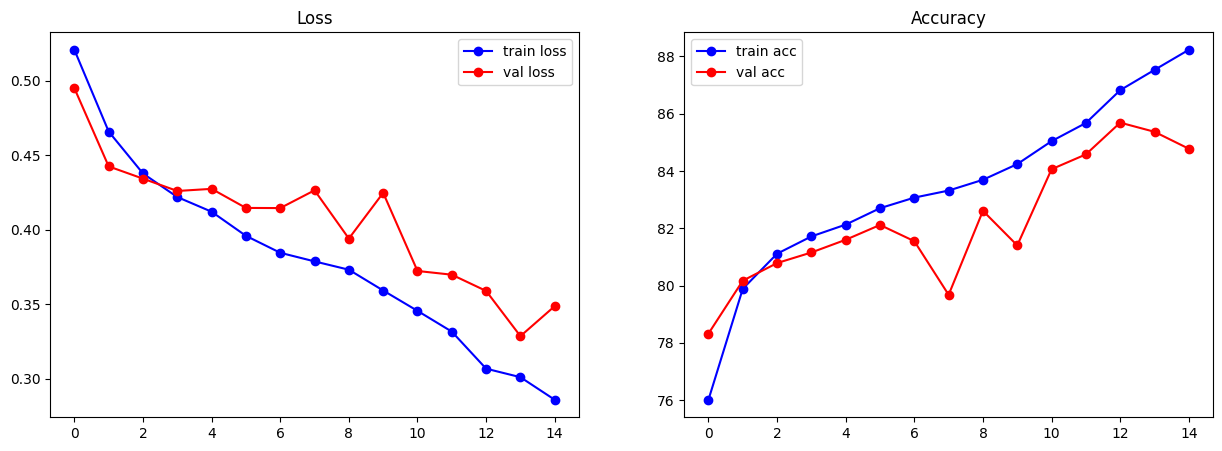

In [26]:
import matplotlib.pyplot as plt

# lets plots the metrics
fig, ax= plt.subplots(nrows = 1, ncols = 2, figsize = (15, 5))
ax[0].plot(metrics_mobileNet['train_loss'], 'bo-', label = 'train loss')
ax[0].plot(metrics_mobileNet['val_loss'], 'ro-', label = 'val loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[1].plot(metrics_mobileNet['train_acc'], 'bo-', label = 'train acc')
ax[1].plot(metrics_mobileNet['val_acc'], 'ro-', label = 'val acc')
ax[1].set_title('Accuracy')
ax[1].legend()
plt.show()

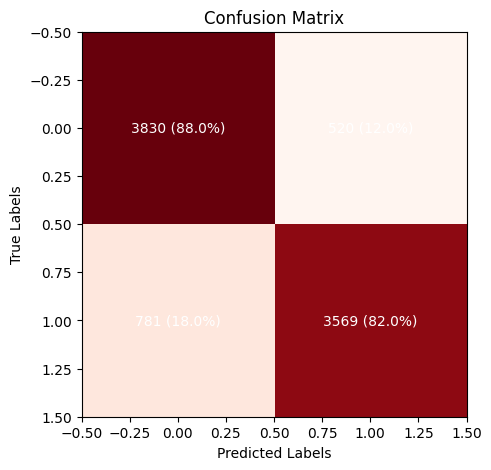

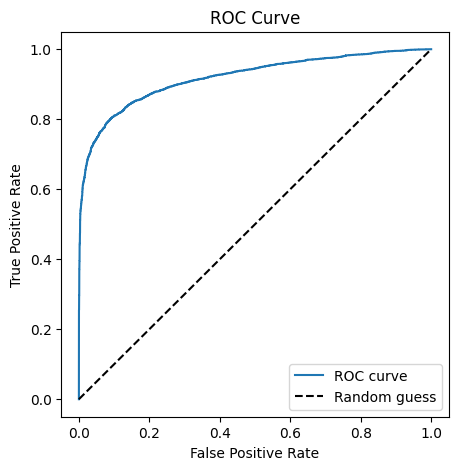

In [27]:
# Lets now test on test data and plot confusion metric as well. Also plot the ROC curve

from sklearn.metrics import confusion_matrix, roc_curve

y_pred = []
y_true = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device).float(), labels.to(device).float().unsqueeze(1)
        outputs = finetuned_MobileNet_model(inputs)
        y_pred.extend(outputs.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

y_pred = np.array(y_pred)
y_true = np.array(y_true)

# lets compute confusion metric and ROC curve
cm = confusion_matrix(y_true, y_pred > 0.5)
# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Reds)
# put the percentage in each cell
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, f'{cm[i, j]} ({cm[i, j]/np.sum(cm[i, :])*100:.1f}%)', ha='center', va='center', color='white')
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

# lets plot the ROC curve
fpr, tpr, _ = roc_curve(y_true, y_pred)
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()